In [2]:
!pip install -q torchinfo

In [22]:
import torch
import torch.nn as nn
from torch.optim import adam
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset,random_split
from torchinfo import summary

import torchvision
from torchvision import datasets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix





## Downloading the dataset from kaggle

In [4]:
from google.colab import files
uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [5]:
!pip install kaggle

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset -p /content

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 98% 2.00G/2.04G [00:12<00:01, 39.1MB/s]
100% 2.04G/2.04G [00:12<00:00, 181MB/s] 


In [8]:
!unzip /content/plantvillage-dataset.zip -d /content/plantvillage

Streaming output truncated to the last 5000 lines.
  inflating: /content/plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: /content/plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: /content/plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: /content/plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: /content/plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: /content/plantvillage/plantvil

In [9]:
import os
data_dir = "/content/plantvillage/plantvillage dataset/color"
classes = os.listdir(data_dir)
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

Number of classes: 38
Classes: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Apple___Cedar_apple_rust', 'Corn_(maize)___healthy', 'Corn_(maize)___Common_rust_', 'Tomato___Early_blight', 'Blueberry___healthy', 'Soybean___healthy', 'Raspberry___healthy', 'Strawberry___Leaf_scorch', 'Peach___Bacterial_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Peach___healthy', 'Apple___Apple_scab', 'Grape___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Potato___Early_blight', 'Tomato___Tomato_mosaic_virus', 'Apple___healthy', 'Pepper,_bell___Bacterial_spot', 'Tomato___Bacterial_spot', 'Cherry_(including_sour)___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Black_rot', 'Squash___Powdery_mildew', 'Potato___healthy', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Late_blight', 'Corn_(maize)___Northern_Leaf_Blight', 'Apple___Black_rot'

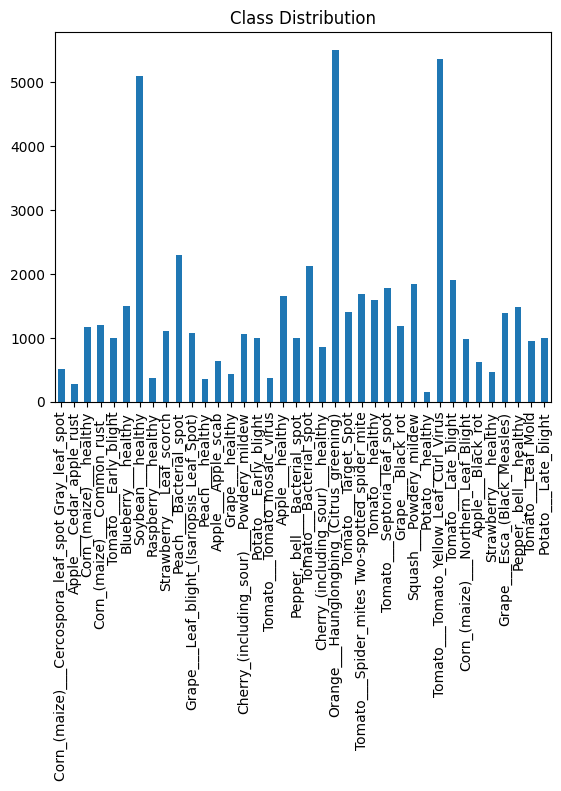

In [10]:
import os

data_dir = "/content/plantvillage/plantvillage dataset/color"
classes = os.listdir(data_dir)
class_counts = {c: len(os.listdir(os.path.join(data_dir, c))) for c in classes}
pd.Series(class_counts).plot(kind="bar")
plt.title("Class Distribution")
plt.show()

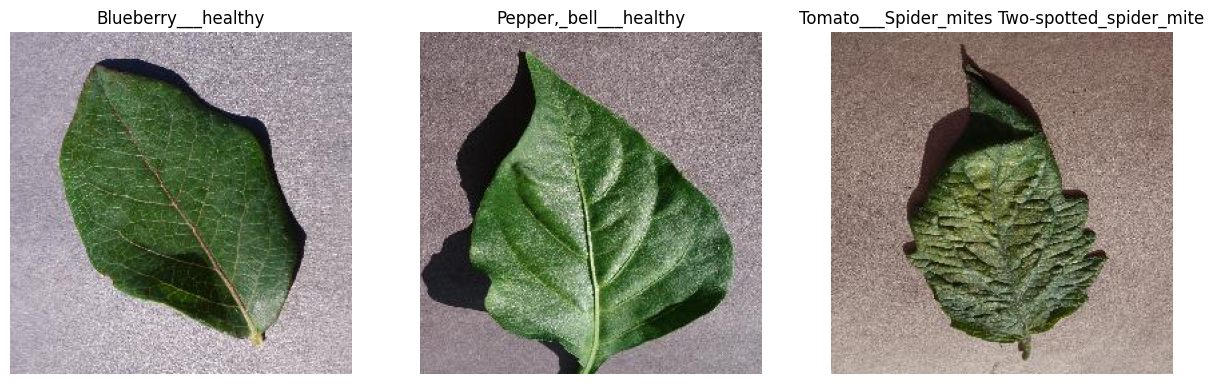

In [11]:
from PIL import Image
import random


def plot_sample_images(data_dir, classes, num_samples=3):
    plt.figure(figsize=(15, 5))
    for i, cls in enumerate(random.sample(classes, num_samples)):
        img_path = random.choice(os.listdir(os.path.join(data_dir, cls)))
        img = Image.open(os.path.join(data_dir, cls, img_path))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.show()

plot_sample_images(data_dir, classes)

In [12]:
from PIL import Image
import random
import numpy as np

def image_properties(data_dir,classes,num_samples=100):
  sizes = []
  for cls in classes:
    for img_path in random.sample(os.listdir(os.path.join(data_dir,cls)),min(5,len(os.listdir(os.path.join(data_dir,cls))))):
      img = Image.open(os.path.join(data_dir,cls,img_path))
      sizes.append(img.size)
  sizes_array = np.array(sizes)
  print(f"Image sizes (width, height): {set(tuple(row) for row in sizes_array)}")
  print(f"Average size: {np.mean(sizes_array, axis=0)}")

image_properties(data_dir,classes)

Image sizes (width, height): {(np.int64(256), np.int64(256))}
Average size: [256. 256.]


In [13]:
from torchvision import transforms

mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]

img_size = ((224,224))

train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0,translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)

])

In [15]:
dataset =  datasets.ImageFolder(data_dir)

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

print("Train dataset size:",len(train_dataset))
print("Validation dataset size:",len(val_dataset))

Train dataset size: 43444
Validation dataset size: 10861


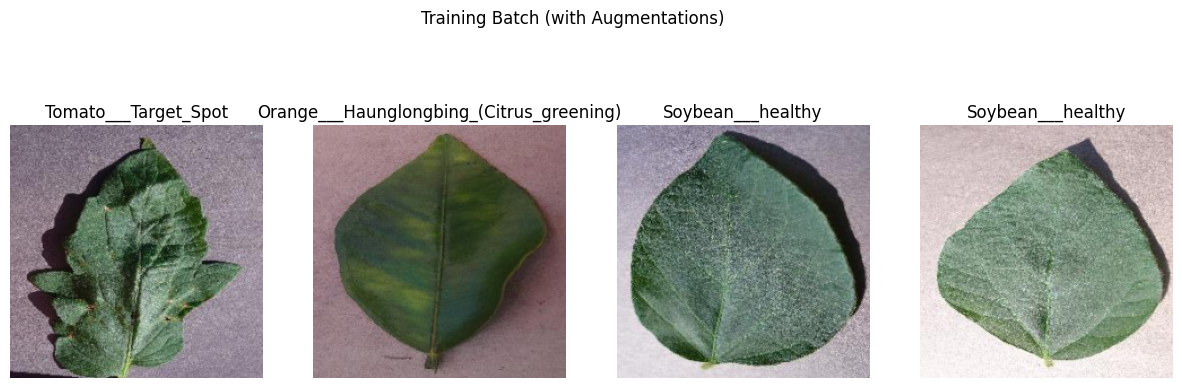

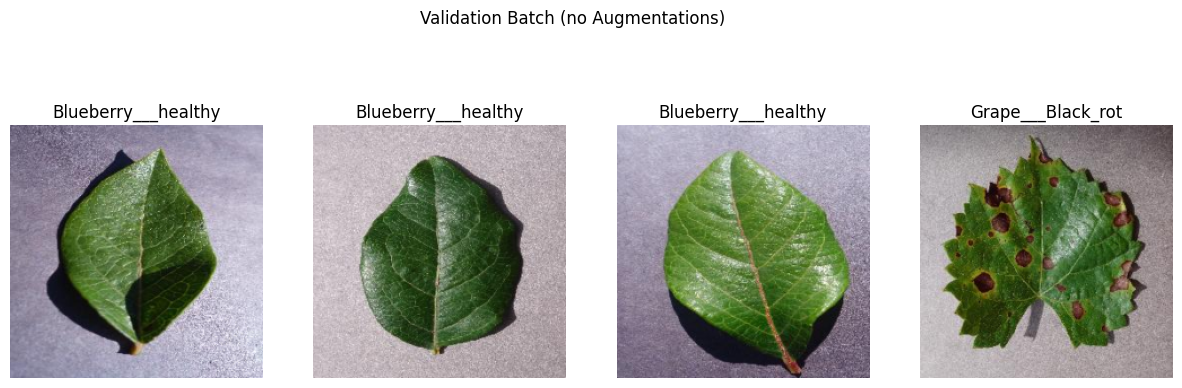

In [16]:
def imshow(img, title=None):
    img = img * torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis("off")

# Visualize training batch (with augmentations)
images, labels = next(iter(train_loader))
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imshow(images[i], title=dataset.classes[labels[i]])
plt.suptitle("Training Batch (with Augmentations)")
plt.show()

# Visualize validation batch (no augmentations)
images, labels = next(iter(val_loader))
plt.figure(figsize=(15, 5))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imshow(images[i], title=dataset.classes[labels[i]])
plt.suptitle("Validation Batch (no Augmentations)")
plt.show()

In [17]:
import torchvision.models as models

model = models.efficientnet_b0(pretrained=True)
num_feature_layers = len(model.features)
print(f"Number of feature layers: {num_feature_layers}")

num_classifier_layers = len(model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 116MB/s] 


Number of feature layers: 9
Number of classifier layers: 2


In [21]:
print(model.classifier[1])

Linear(in_features=1280, out_features=1000, bias=True)


In [24]:
num_classes = 38
model.classifier[1] = nn.Linear(model.classifier[1].in_features,num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [25]:
for param in model.features[-3].parameters():
  param.requires_grad = False

for param in model.classifier.parameters():
  param.requires_grad = True


In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(),lr=0.001)

In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):

        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= train_total
        train_acc = 100 * train_correct / train_total


        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= val_total
        val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return model


model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5: Train Loss: 0.5360, Train Acc: 87.95%, Val Loss: 0.1922, Val Acc: 95.14%
Epoch 2/5: Train Loss: 0.2082, Train Acc: 94.07%, Val Loss: 0.1411, Val Acc: 95.92%
Epoch 3/5: Train Loss: 0.1693, Train Acc: 94.78%, Val Loss: 0.1215, Val Acc: 96.35%
Epoch 4/5: Train Loss: 0.1485, Train Acc: 95.28%, Val Loss: 0.1135, Val Acc: 96.41%
Epoch 5/5: Train Loss: 0.1367, Train Acc: 95.69%, Val Loss: 0.1134, Val Acc: 96.48%


Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.92      0.93       121
                                 Apple___Black_rot       0.98      1.00      0.99       120
                          Apple___Cedar_apple_rust       0.98      0.97      0.98        61
                                   Apple___healthy       0.99      0.98      0.99       331
                               Blueberry___healthy       0.99      0.99      0.99       344
          Cherry_(including_sour)___Powdery_mildew       0.98      0.99      0.98       230
                 Cherry_(including_sour)___healthy       0.99      0.98      0.99       148
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.70      0.86      0.77       103
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       219
               Corn_(maize)___Northern_Leaf_Blight      

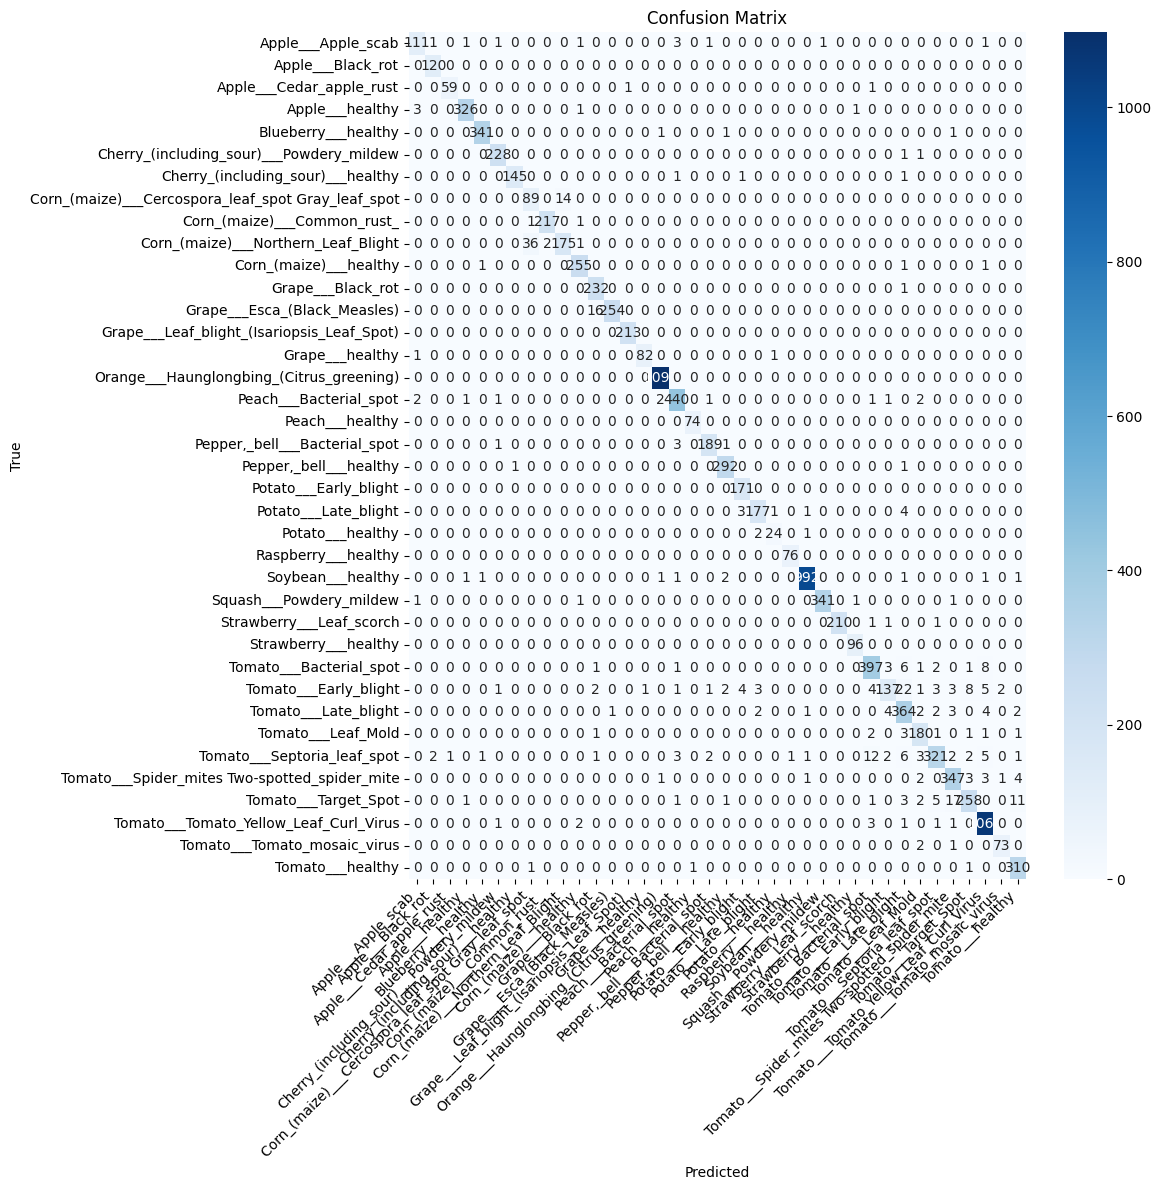

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, val_loader, dataset):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Classification report
    print("Classification Report:")
    print(classification_report(true_labels, preds, target_names=dataset.classes))

    # Confusion matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Evaluate the model
evaluate_model(model, val_loader, dataset)

## Saving the model and the classes

In [32]:
torch.save(model.state_dict(),'model.pth')

In [33]:
import json
with open('classes.json','w') as f:
  json.dump(dataset.classes,f)